In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import pickle
sys.path.append(os.path.abspath(os.path.join("../")))
sys.path.append(os.path.abspath(os.path.join("../", "lib", "pysgmcmc/")))
sys.path.append(os.path.abspath(os.path.join("../", "lib", "smoothing/")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Training model
from models.continual_training_dyn import TrainingDynamics

/home/thobotics/anaconda2/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generate data 

In [3]:
def f(x):
#     return np.sin(x)
    # return 1.5*np.sinc(x) - 0.5
    return 1.5*np.sinc(0.5*x - 2.5) - 0.15

def generate_data(sample_size=2000, low=-2*math.pi, high=-math.pi, seed=42):
    def sinus_model(x):
        return np.sin(1.5*x + np.pi/8.)

    rng = np.random.seed(seed)
    
    x = np.random.uniform(low=low, high=high, size=(sample_size,))
    y = f(x) + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

def generate_original_data(sample_size = 2000, seed=42):
    def sinus_model(x):
        return np.sin(1.5*x + np.pi/8.)

    rng = np.random.seed(seed)
    
#     x1 = np.random.uniform(low=-2*math.pi, high=-math.pi, size=(sample_size // 2,))
#     x2 = np.random.uniform(low=math.pi, high=2*math.pi, size=(sample_size // 2,))
# #     x2 = np.random.uniform(low=-1.0, high=2., size=(sample_size // 2,))
#     x = np.hstack([x1, x2])
    x = np.random.uniform(low=-2*math.pi, high=-math.pi, size=(sample_size))
    y = f(x) + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

In [4]:
# Generate data
x_train, y_train = generate_original_data(500)

x_validate = np.arange(-10., 10., 0.01)
y_validate = f(x_validate)

# Convert to matrix
x_train = x_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

x_validate = x_validate[:, np.newaxis]
y_validate = y_validate[:, np.newaxis]

In [5]:
def plot_model(x_tr=None, y_tr=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(x_train, y_train, color = 'blue', s = 15.5)
    
    if x_tr is not None:
        plt.scatter(x_tr, y_tr, color = 'k', s = 1.5)
    
    plt.xlim([-8., 8.])
    plt.ylim([-1.5, 1.5])

    plt.grid()
    plt.show()

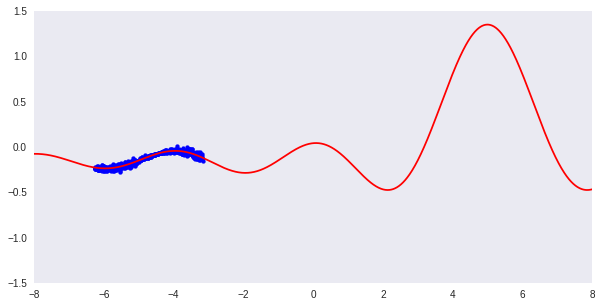

In [6]:
plot_model()

## Training 

In [7]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

tf.reset_default_graph()

# Create model
n_timestep = 1
n_inputs  = 1
n_outputs = 1

training = TrainingDynamics(n_inputs, n_outputs, n_timestep, action_bounds=([-1., -1.57], [1., 1.57]),
                          model_type="BNN", n_nets=15, n_units=500, scale=1.5,
                          activation=tf.tanh, batch_size=100, a0=1.0, b0=0.1, a1=1.0, b1=5.0)

DEBUG:root:num_training_dynamics_adam_variables 18


In [8]:
# Add data
u_train = np.array([]).reshape(x_train.shape[0], 0)
training.add_data(x_train, u_train, y_train)

In [9]:
training.run_bnn(x_validate, y_validate, 
                 run_normal=True, normal_max_iters=3000,
                 step_size=2.0e-3, mdecay=0.05, burn_in_steps=1000, n_iters=250000, sample_steps=150)

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 116.20853424072266 
	NLL_val = 9971.634765625 
	MSE     = 23.494224548339844 
	MSE_val = 1996.55224609375 
Time =  0.35
INFO:root:Iter      250 : 
	NLL     = 7.658127307891846 
	NLL_val = 5682.79248046875 
	MSE     = 1.9511314630508423 
	MSE_val = 1267.4613037109375 
Time =  2.03
INFO:root:Iter      500 : 
	NLL     = 6.0278544425964355 
	NLL_val = 4997.5771484375 
	MSE     = 1.7199018001556396 
	MSE_val = 1214.853271484375 
Time =  3.79
INFO:root:Iter      750 : 
	NLL     = 5.812726974487305 
	NLL_val = 4496.42626953125 
	MSE     = 1.8167028427124023 
	MSE_val = 1198.798583984375 
Time =  5.46
INFO:root:Iter     1000 : 
	NLL     = 4.672471046447754 
	NLL_val = 4077.863525390625 
	MSE     = 1.6590795516967773 
	MSE_val = 1203.0706787109375 
Time =  7.14
INFO:root:Iter     1250 : 
	NLL     = 4.075284004211426 
	NLL_val = 3707.496337890625 
	MSE     = 1.629070520401001 
	MSE_val = 1214

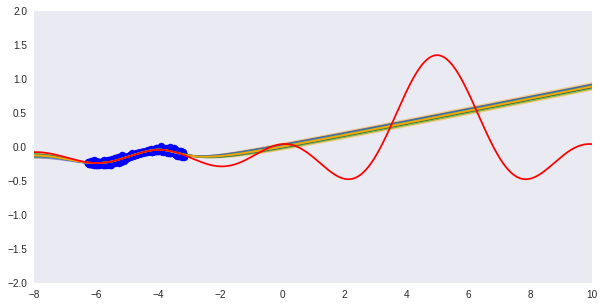

In [10]:
def plot_bnn_model(x_new=None, y_new=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()

    color = ['green', 'k', 'yellow', 'cyan', "blue"]
    
    for i in range(training.model.n_nets):
        y_pred, _ = training.predict(x_validate, return_individual_predictions=True, model_idx=i)
        plt.plot(x_validate, y_pred, color[i % 5], alpha=0.35)
    
    mu_pred, var_pred = training.predict(x_validate, return_individual_predictions=False)
    plt.plot(x_validate, mu_pred, "orange", alpha=1.0)
    plt.fill_between(x_validate[:, 0], 
                     (mu_pred + np.sqrt(var_pred))[:, 0], 
                     (mu_pred - np.sqrt(var_pred))[:, 0], alpha=0.8, color="orange")
    
    plt.fill_between(x_validate[:, 0], 
                     (mu_pred + 2 * np.sqrt(var_pred))[:, 0], 
                     (mu_pred - 2 * np.sqrt(var_pred))[:, 0], alpha=0.6, color="orange")
    
    plt.fill_between(x_validate[:, 0], 
                     (mu_pred + 3 * np.sqrt(var_pred))[:, 0], 
                     (mu_pred - 3 * np.sqrt(var_pred))[:, 0], alpha=0.4, color="orange")
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(training.xu, training.y, color='blue', s=50.5)
    
    if x_new is not None:
        plt.scatter(x_new, y_new, color='black', s=50.5)
    
    # Plot last model
    # y_pred, _ = training.predict(x_validate, normal=True, return_individual_predictions=True, model_idx=training.model.n_nets-1)
    # plt.plot(x_validate, y_pred, "black", alpha=1.0, linewidth=3)
    
    plt.xlim([-8., 10.])
    plt.ylim([-2.0, 2.0])

    plt.grid()
    plt.show()
        
plot_bnn_model()

In [11]:
Q_new, lambda_new = training._get_covariances()
print(Q_new, "\n", "\n", lambda_new)

[[0.4358364]] 
 
 13.656571


# Online Learning

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 28.26343536376953 
	NLL_val = 944.5323486328125 
	MSE     = 25.019739151000977 
	MSE_val = 824.5079345703125 
Time =  0.02
INFO:root:Iter      250 : 
	NLL     = 0.9937337636947632 
	NLL_val = 924.4910278320312 
	MSE     = 1.2439745664596558 
	MSE_val = 825.76708984375 
Time =  2.09
INFO:root:Iter      500 : 
	NLL     = 0.9736430048942566 
	NLL_val = 912.7457275390625 
	MSE     = 1.2370103597640991 
	MSE_val = 826.785400390625 
Time =  4.18
INFO:root:Iter      750 : 
	NLL     = 0.9676936864852905 
	NLL_val = 896.1088256835938 
	MSE     = 1.2460911273956299 
	MSE_val = 826.8639526367188 
Time =  6.26
INFO:root:Iter     1000 : 
	NLL     = 0.9552517533302307 
	NLL_val = 877.4058227539062 
	MSE     = 1.2512518167495728 
	MSE_val = 827.1211547851562 
Time =  8.37
INFO:root:Iter     1250 : 
	NLL     = 0.9607182741165161 
	NLL_val = 854.2227172851562 
	MSE     = 1.2775250673294067 
	MSE_val

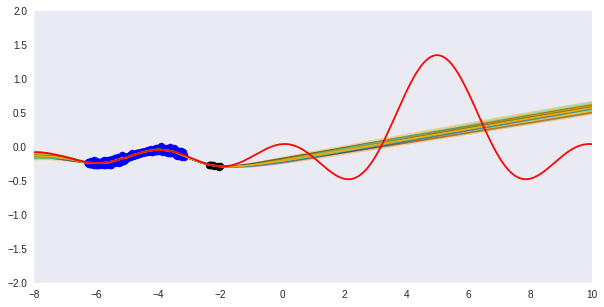

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 7.109245300292969 
	NLL_val = 615.5809326171875 
	MSE     = 10.63101863861084 
	MSE_val = 901.5370483398438 
Time =  0.01
INFO:root:Iter      250 : 
	NLL     = 0.7924864292144775 
	NLL_val = 519.3316040039062 
	MSE     = 1.3962081670761108 
	MSE_val = 776.7675170898438 
Time =  0.95
INFO:root:Iter      500 : 
	NLL     = 0.6631622910499573 
	NLL_val = 516.0559692382812 
	MSE     = 1.2073777914047241 
	MSE_val = 779.1860961914062 
Time =  2.06
INFO:root:Iter      750 : 
	NLL     = 0.7166398763656616 
	NLL_val = 509.5699768066406 
	MSE     = 1.2937473058700562 
	MSE_val = 777.2587280273438 
Time =  3.01
INFO:root:Iter     1000 : 
	NLL     = 0.6753495931625366 
	NLL_val = 505.25927734375 
	MSE     = 1.2359950542449951 
	MSE_val = 779.010009765625 
Time =  3.95
INFO:root:Iter     1250 : 
	NLL     = 0.7016434073448181 
	NLL_val = 503.26568603515625 
	MSE     = 1.2812150716781616 
	MSE_val

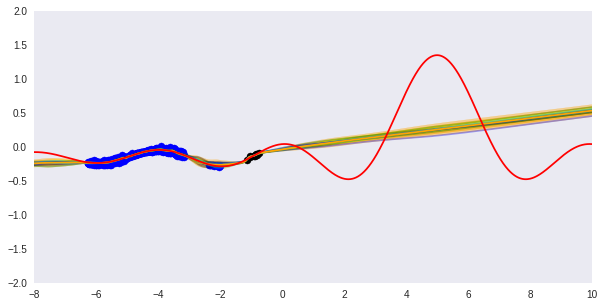

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 7.5447306632995605 
	NLL_val = 400.9918518066406 
	MSE     = 11.335417747497559 
	MSE_val = 591.000732421875 
Time =  0.01
INFO:root:Iter      250 : 
	NLL     = 0.5184811353683472 
	NLL_val = 414.1210632324219 
	MSE     = 0.9866626858711243 
	MSE_val = 617.3970947265625 
Time =  0.89
INFO:root:Iter      500 : 
	NLL     = 0.49502018094062805 
	NLL_val = 408.35418701171875 
	MSE     = 0.9520130157470703 
	MSE_val = 609.5342407226562 
Time =  1.76
INFO:root:Iter      750 : 
	NLL     = 0.4518544375896454 
	NLL_val = 403.26904296875 
	MSE     = 0.8878744840621948 
	MSE_val = 602.9953002929688 
Time =  2.62
INFO:root:Iter     1000 : 
	NLL     = 0.46572813391685486 
	NLL_val = 404.4839172363281 
	MSE     = 0.9088829159736633 
	MSE_val = 605.8071899414062 
Time =  3.53
INFO:root:Iter     1250 : 
	NLL     = 0.4979727566242218 
	NLL_val = 404.04107666015625 
	MSE     = 0.9575614333152771 
	MS

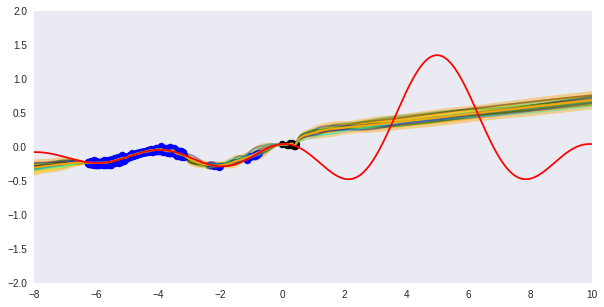

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 12.300621032714844 
	NLL_val = 329.3266296386719 
	MSE     = 15.954182624816895 
	MSE_val = 419.8580322265625 
Time =  0.02
INFO:root:Iter      250 : 
	NLL     = 0.40098270773887634 
	NLL_val = 354.12188720703125 
	MSE     = 0.7949457168579102 
	MSE_val = 455.01910400390625 
Time =  0.87
INFO:root:Iter      500 : 
	NLL     = 0.29639294743537903 
	NLL_val = 359.513671875 
	MSE     = 0.6603156328201294 
	MSE_val = 455.534423828125 
Time =  1.72
INFO:root:Iter      750 : 
	NLL     = 0.24270331859588623 
	NLL_val = 364.2690734863281 
	MSE     = 0.5929581522941589 
	MSE_val = 453.19769287109375 
Time =  2.59
INFO:root:Iter     1000 : 
	NLL     = 0.2526973485946655 
	NLL_val = 373.8702697753906 
	MSE     = 0.6055842638015747 
	MSE_val = 454.46539306640625 
Time =  3.48
INFO:root:Iter     1250 : 
	NLL     = 0.2515315115451813 
	NLL_val = 384.3768310546875 
	MSE     = 0.6040201783180237 
	M

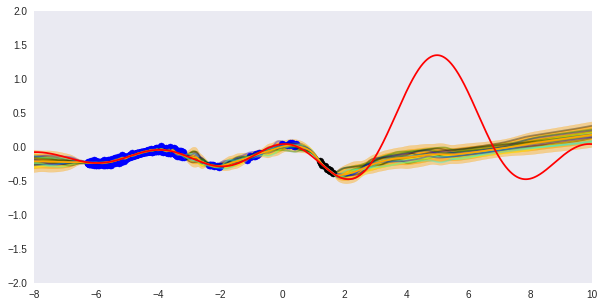

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 13.603066444396973 
	NLL_val = 746.1864013671875 
	MSE     = 9.834039688110352 
	MSE_val = 519.7960815429688 
Time =  0.01
INFO:root:Iter      250 : 
	NLL     = 0.13575036823749542 
	NLL_val = 486.7523193359375 
	MSE     = 0.4609013795852661 
	MSE_val = 344.2330017089844 
Time =  0.88
INFO:root:Iter      500 : 
	NLL     = 0.10628337413072586 
	NLL_val = 485.3890380859375 
	MSE     = 0.4399656355381012 
	MSE_val = 342.803955078125 
Time =  1.72
INFO:root:Iter      750 : 
	NLL     = 0.09634464234113693 
	NLL_val = 482.43603515625 
	MSE     = 0.4328151047229767 
	MSE_val = 340.13543701171875 
Time =  2.60
INFO:root:Iter     1000 : 
	NLL     = 0.17593640089035034 
	NLL_val = 477.0328063964844 
	MSE     = 0.4884798228740692 
	MSE_val = 335.3775329589844 
Time =  3.44
INFO:root:Iter     1250 : 
	NLL     = 0.09408728033304214 
	NLL_val = 481.5753173828125 
	MSE     = 0.4307720363140106 
	M

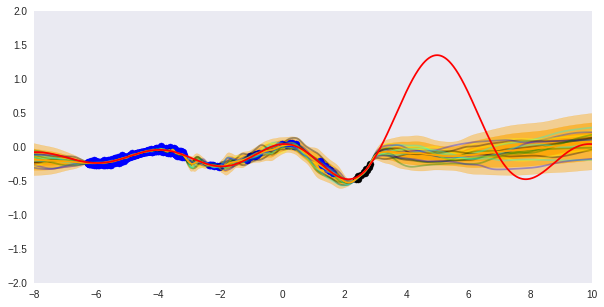

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 98.17312622070312 
	NLL_val = 160.46896362304688 
	MSE     = 61.92285919189453 
	MSE_val = 100.98870849609375 
Time =  0.01
INFO:root:Iter      250 : 
	NLL     = -0.46281373500823975 
	NLL_val = 140.07627868652344 
	MSE     = 0.06882534921169281 
	MSE_val = 88.9947280883789 
Time =  0.99
INFO:root:Iter      500 : 
	NLL     = -0.4762439429759979 
	NLL_val = 140.76773071289062 
	MSE     = 0.06267821043729782 
	MSE_val = 88.62871551513672 
Time =  1.96
INFO:root:Iter      750 : 
	NLL     = -0.47874680161476135 
	NLL_val = 142.10556030273438 
	MSE     = 0.06423086673021317 
	MSE_val = 88.36412811279297 
Time =  3.13
INFO:root:Iter     1000 : 
	NLL     = -0.48572731018066406 
	NLL_val = 143.4546661376953 
	MSE     = 0.06380832940340042 
	MSE_val = 87.7995376586914 
Time =  4.04
INFO:root:Iter     1250 : 
	NLL     = -0.48198437690734863 
	NLL_val = 145.36419677734375 
	MSE     = 0.0704640

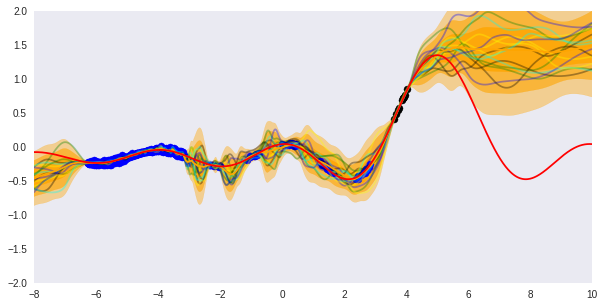

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 45.94847869873047 
	NLL_val = 1330.601806640625 
	MSE     = 6.144478797912598 
	MSE_val = 172.99305725097656 
Time =  0.02
INFO:root:Iter      250 : 
	NLL     = -0.8836333155632019 
	NLL_val = 1493.416015625 
	MSE     = 0.062001049518585205 
	MSE_val = 196.4276123046875 
Time =  0.97
INFO:root:Iter      500 : 
	NLL     = -0.9568495750427246 
	NLL_val = 1452.2493896484375 
	MSE     = 0.052396390587091446 
	MSE_val = 190.88772583007812 
Time =  1.94
INFO:root:Iter      750 : 
	NLL     = -1.0414408445358276 
	NLL_val = 1440.884033203125 
	MSE     = 0.04132922738790512 
	MSE_val = 189.09849548339844 
Time =  2.92
INFO:root:Iter     1000 : 
	NLL     = -1.0751398801803589 
	NLL_val = 1460.0950927734375 
	MSE     = 0.036976996809244156 
	MSE_val = 191.17701721191406 
Time =  3.89
INFO:root:Iter     1250 : 
	NLL     = -1.0019065141677856 
	NLL_val = 1472.6263427734375 
	MSE     = 0.04660572

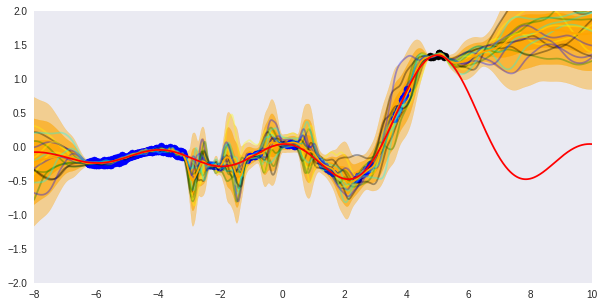

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 155.89727783203125 
	NLL_val = 1063.737548828125 
	MSE     = 12.325690269470215 
	MSE_val = 83.36807250976562 
Time =  0.02
INFO:root:Iter      250 : 
	NLL     = -0.4446462392807007 
	NLL_val = 213.34776306152344 
	MSE     = 0.09236185252666473 
	MSE_val = 17.137664794921875 
Time =  1.22
INFO:root:Iter      500 : 
	NLL     = -0.5690200328826904 
	NLL_val = 197.8582763671875 
	MSE     = 0.08240878582000732 
	MSE_val = 15.881328582763672 
Time =  2.18
INFO:root:Iter      750 : 
	NLL     = -1.1350010633468628 
	NLL_val = 189.64199829101562 
	MSE     = 0.0373622328042984 
	MSE_val = 15.20365047454834 
Time =  3.15
INFO:root:Iter     1000 : 
	NLL     = -1.0763760805130005 
	NLL_val = 176.59442138671875 
	MSE     = 0.04202297329902649 
	MSE_val = 14.12662410736084 
Time =  4.15
INFO:root:Iter     1250 : 
	NLL     = -1.0621980428695679 
	NLL_val = 183.87078857421875 
	MSE     = 0.04318058

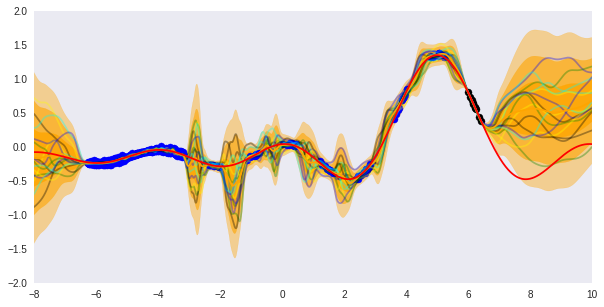

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 251.514892578125 
	NLL_val = 947.4932250976562 
	MSE     = 16.635494232177734 
	MSE_val = 62.35969924926758 
Time =  0.02
INFO:root:Iter      250 : 
	NLL     = 8.423318862915039 
	NLL_val = 106.64237976074219 
	MSE     = 0.6767286062240601 
	MSE_val = 7.248940467834473 
Time =  1.84
INFO:root:Iter      500 : 
	NLL     = 1.207139015197754 
	NLL_val = 83.69981384277344 
	MSE     = 0.1939433217048645 
	MSE_val = 5.71555233001709 
Time =  3.55
INFO:root:Iter      750 : 
	NLL     = 0.6795060038566589 
	NLL_val = 88.25394439697266 
	MSE     = 0.15864036977291107 
	MSE_val = 6.020901203155518 
Time =  5.30
INFO:root:Iter     1000 : 
	NLL     = -1.0883097648620605 
	NLL_val = 88.47540283203125 
	MSE     = 0.04030996561050415 
	MSE_val = 6.035746097564697 
Time =  7.07
INFO:root:Iter     1250 : 
	NLL     = -1.1793639659881592 
	NLL_val = 91.22420501708984 
	MSE     = 0.03421503305435181 
	MS

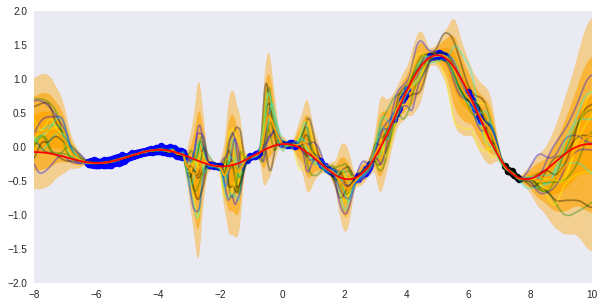

In [12]:
from IPython import display

start = -math.pi + 0.7

for i in range(9):
    
    x_train_new = np.array([]).reshape((0, 1))
    y_train_new = np.array([]).reshape((0, 1))
    
    for j in range(1):
        # x_new, y_new = generate_data(10, low=-math.pi + i*0.5, high=0.5*math.pi + i*0.5, seed=22 + i*5)
        x_new, y_new = generate_data(10, low=start, high=start+0.5, seed=22 + i*5)
        start = start + 0.5 + 0.7

        x_train_new = np.vstack([x_train_new, x_new[:, np.newaxis]])
        y_train_new = np.vstack([y_train_new, y_new[:, np.newaxis]])
    
    u_train_new = np.array([]).reshape(x_train_new.shape[0], 0)

    # Fit data
    training._fit(x_train_new, u_train_new, y_train_new)

    training.run_bnn(x_validate, y_validate, x_train_new, y_train_new, 
                     run_normal=True, normal_max_iters=5000,
                     step_size=5.0e-3, mdecay=0.05, burn_in_steps=1000, n_iters=250000, sample_steps=200)
    
#     training.add_data(x_train_new, u_train_new, y_train_new)

#     training.run_normal(x_validate, y_validate, step_size=1e-3, max_iters=2000)
#     training.run_bnn(x_validate, y_validate, step_size=2.0e-3, mdecay=0.05, burn_in_steps=3000, n_iters=250000, sample_steps=100)

    plot_bnn_model(x_train_new, y_train_new)

    # Add data
    training.add_data(x_train_new, u_train_new, y_train_new, fit=False)
    
    display.display()

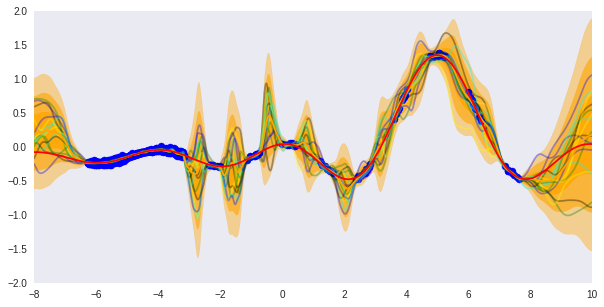

In [13]:
plot_bnn_model()

In [14]:
Q_new, lambda_new = training._get_covariances()
print(Q_new, "\n", "\n", lambda_new)

[[0.03987288]] 
 
 6.4256287


In [15]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

tf.reset_default_graph()

# Create model
n_timestep = 1
n_inputs  = 1
n_outputs = 1

training_new = TrainingDynamics(n_inputs, n_outputs, n_timestep, action_bounds=([-1., -1.57], [1., 1.57]),
                          model_type="BNN", n_nets=15, n_units=500, scale=1.5,
                          activation=tf.tanh, batch_size=100, a0=1.0, b0=0.1, a1=1.0, b1=5.0)

# Add data
x_train = training.xu
y_train = training.y
u_train = np.array([]).reshape(x_train.shape[0], 0)
training_new.add_data(x_train, u_train, y_train)

training_new.run_normal(x_validate, y_validate, step_size=1e-3, max_iters=5000)
training_new.run_bnn(x_validate, y_validate, step_size=5.0e-3, mdecay=0.05, burn_in_steps=10000, n_iters=250000, sample_steps=200)

DEBUG:root:num_training_dynamics_adam_variables 18
INFO:root:Reinitialize dynamics Adam
INFO:root:Start Adam Training
INFO:root:Iter        0 : 
	NLL     = 310.69500732421875 
	NLL_val = 1654.1512451171875 
	MSE     = 62.430606842041016 
	MSE_val = 331.39141845703125 
Time =  0.16
INFO:root:Iter      250 : 
	NLL     = 25.583784103393555 
	NLL_val = 116.79588317871094 
	MSE     = 5.551987171173096 
	MSE_val = 24.511247634887695 
Time =  2.19
INFO:root:Iter      500 : 
	NLL     = 25.7020206451416 
	NLL_val = 202.87417602539062 
	MSE     = 5.881978511810303 
	MSE_val = 44.76419448852539 
Time =  4.47
INFO:root:Iter      750 : 
	NLL     = 34.782894134521484 
	NLL_val = 315.08380126953125 
	MSE     = 8.25279426574707 
	MSE_val = 72.76226806640625 
Time =  6.86
INFO:root:Iter     1000 : 
	NLL     = 27.904308319091797 
	NLL_val = 258.3658447265625 
	MSE     = 7.046846866607666 
	MSE_val = 63.138954162597656 
Time =  9.25
INFO:root:Iter     1250 : 
	NLL     = 22.413869857788086 
	NLL_val = 147

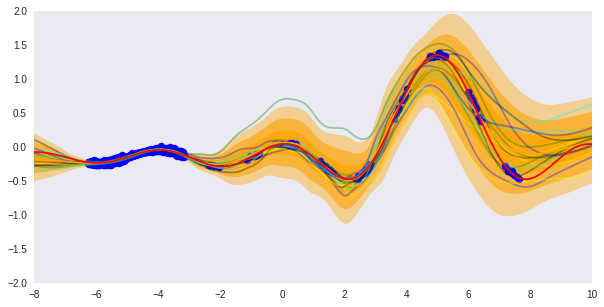

In [16]:
 # Setup state for plotting
plt.rcParams['figure.figsize'] = (10, 5)               
fig = plt.figure()

color = ['green', 'k', 'yellow', 'cyan', "blue"]

for i in range(training.model.n_nets):
    y_pred, _ = training_new.predict(x_validate, return_individual_predictions=True, model_idx=i)
    plt.plot(x_validate, y_pred, color[i % 5], alpha=0.35)

mu_pred, var_pred = training_new.predict(x_validate, return_individual_predictions=False)
plt.plot(x_validate, mu_pred, "orange", alpha=1.0)
plt.fill_between(x_validate[:, 0], 
                 (mu_pred + np.sqrt(var_pred))[:, 0], 
                 (mu_pred - np.sqrt(var_pred))[:, 0], alpha=0.8, color="orange")

plt.fill_between(x_validate[:, 0], 
                 (mu_pred + 2 * np.sqrt(var_pred))[:, 0], 
                 (mu_pred - 2 * np.sqrt(var_pred))[:, 0], alpha=0.6, color="orange")

plt.fill_between(x_validate[:, 0], 
                 (mu_pred + 3 * np.sqrt(var_pred))[:, 0], 
                 (mu_pred - 3 * np.sqrt(var_pred))[:, 0], alpha=0.4, color="orange")

plt.plot(x_validate, y_validate, 'r', label = '$m$')
plt.scatter(training_new.xu, training_new.y, color='blue', s=50.5)

# Plot last model
#y_pred, _ = training.predict(x_validate, normal=True, return_individual_predictions=True, model_idx=training.model.n_nets-1)
#plt.plot(x_validate, y_pred, "black", alpha=1.0, linewidth=3)

plt.xlim([-8., 10.])
plt.ylim([-2.0, 2.0])

plt.grid()
plt.show()